In [1]:
%matplotlib inline
%load_ext memory_profiler

import os 
import glob 
import sys
sys.path.append('/home/ngr4/project/edge_feat/scripts')
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils
import load_data as data
import math
import numpy as np
import pandas as pd
import seaborn as sns
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import graphtools as gt
import phate
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scanpy as sc
from scipy import sparse
import scprep
import time
import datetime
from scipy.stats import zscore
from adjustText import adjust_text


from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

from captum.attr import (
#     GradientShap,
#     DeepLift,
#     DeepLiftShap,
    IntegratedGradients,
#     LayerConductance,
#     NeuronConductance,
    NoiseTunnel,
)



plt.rc('font', size = 8)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
sns.set_style("ticks")

In [2]:
class Encoder(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, s_max, d_model, num_heads, ln=False, skip=True):
        super(Encoder, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.skip = skip
        self.s_max = s_max
        #Maximum set size
        self.d_model = d_model
        self.fc_q = nn.Linear(dim_Q, d_model)
        self.fc_k = nn.Linear(dim_K, d_model)
        self.fc_v = nn.Linear(dim_K, d_model)
        if ln:
            self.ln0 = nn.LayerNorm(d_model)
            self.ln1 = nn.LayerNorm(d_model)
        #This is the classic pointwise feedforward in "Attention is All you need"
        self.ff = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.ReLU(),
        nn.Linear(4 * d_model, d_model))
        self.fc_rep = nn.Linear(s_max, 1)
        
    # number of heads must divide output size = d_model
    def forward(self, Q, K, return_attention, return_A):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)
        dim_split = self.d_model // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)
        A = torch.softmax(Q_.bmm(K_.transpose(-2,-1))/math.sqrt(self.d_model), dim=-1)
        A_1 = A.bmm(V_) 
        O = torch.cat((A_1).split(Q.size(0), 0), 2) 
        if return_attention:
            attn = O
        O = torch.cat((Q_ + A_1).split(Q.size(0), 0), 2) if getattr(self, 'skip', True) else \
             torch.cat((A_1).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)

        # For the classic transformers paper it is
        O = O + self.ff(O)
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        O = O.transpose(-2,-1)
        O = F.pad(O, (0, self.s_max- O.shape[-1]), 'constant', 0)
        O = self.fc_rep(O)
        O = O.squeeze() 
        if return_attention:
            return O, attn
        elif return_A:
            return O, A
        else:
            return O
    
class SelfAttention_batch(nn.Module):
    def __init__(self, s_max, dim_in=18, dim_out=8, num_heads=2, ln=True, skip=True):
        super(SelfAttention_batch, self).__init__()
        self.Encoder = Encoder(dim_in, dim_in, dim_in, s_max, dim_out, num_heads, ln=ln, skip=skip)
        
    def forward(self, X, return_attention=True, return_A=False):
        return self.Encoder(X, X, return_attention, return_A)
    
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=d.y.unique().size()[0],
                                 heads=8, concat=False, negative_slope=0.2,
                                 dropout=0.4, bias=True)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        hprime = x # store embeddings 
        x = F.elu(x)
        x, attn_gat2 = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1), attn_gat1, attn_gat2, hprime
    
    
class GAT_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GAT_transformer_mlp_batch, self).__init__()
        self.gat1 = data.GATConv(d.num_node_features, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.gat2 = data.GATConv(8*8, out_channels=8,
                                 heads=8, concat=True, negative_slope=0.2,
                                 dropout=0.4, bias=True)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x, attn_gat1 = self.gat1(x, edge_index)
        x = F.elu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x, attn_gat2 = self.gat2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans, attn_gat1, attn_gat2
    
class GCN_transformer_mlp_batch(torch.nn.Module):
    def __init__(self):
        super(GCN_transformer_mlp_batch, self).__init__()
        self.conv1 = GCNConv(d.num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.transformer = SelfAttention_batch(s_max)
        self.linear = nn.Linear(72, d.y.unique().size()[0])

    def forward(self, data, edge_feats):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x_t, attn_trans = self.transformer(edge_feats)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.linear(torch.cat((x,x_t),dim=1))
        return F.log_softmax(x, dim=1), attn_trans
    
    
# other utils fx 
def load_pkl(fname):
    with open(fname, 'rb') as f:
        data = pickle.load(f)
        f.close()
    return data

def adata_phate(adata):
    # compute PHATE
    G = gt.Graph(data=adata.obsp['connectivities']+sparse.diags([1]*adata.shape[0],format='csr'),
                 precomputed='adjacency',
                 use_pygsp=True)
    G.knn_max = None
    
    phate_op = phate.PHATE(knn_dist='precomputed',
                           gamma=0,
                           random_state=42)
    adata.obsm['X_phate']=phate_op.fit_transform(G.K)
    
    return adata

In [3]:
def main(d, **kwargs):
    
    batch_it = False 
    
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        s_max = kwargs['s_max']
        if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GCN_transformer_mlp_batch()
        elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            model = GAT_transformer_mlp_batch()
    elif 'GAT'== kwargs['model']:
        model = GAT()
    model.eval()
    model.load_state_dict(torch.load(kwargs['modeleval_pkl'], map_location=torch.device('cpu')))
    
    if batch_it:
        # TODO: not implemented for GCN 
        cd_test = data.ClusterData(d,5000)
        cl_test = data.ClusterLoader(cd_test,256,shuffle=True)

        batch_loss_test = []
        batch_acc_test = []

        for batch in cl_test:
            output, attn_trans, attn_gat1, attn_gat2 = model(batch, utils.edge_set_reshape(batch).float())
            loss_test = F.nll_loss(output, batch.y)
            batch_acc_test.append(utils.accuracy(output,batch.y).item())
            batch_loss_test.append(loss_test.item())
        print('Test set results:')
        print('  <loss>_bacth={:.4f}'.format(np.mean(batch_loss_test)))
        print('  <acc>_batch ={:.4f}'.format(np.mean(batch_acc_test)))
    else:
        if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
            if 'gcn' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans = model(d, utils.edge_set_reshape(d).float())
            elif 'gat' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
                output, attn_trans, attn_gat1, attn_gat2 = model(d, utils.edge_set_reshape(d).float())
        elif 'GAT'== kwargs['model']:
            output, attn_gat1, attn_gat2, hprime = model(d)
        loss_test = F.nll_loss(output, d.y)
        acc_test = utils.accuracy(output,d.y).item()
        print('Test set results:')
        print('  loss: {:.4f}'.format(loss_test))
        print('  accuracy: {:.4f}'.format(acc_test))
        
    datapkl = load_pkl(kwargs['data_pkl'])
    if 'trans' in os.path.split(kwargs['modeleval_pkl'])[1].lower():
        return attn_gat1, attn_trans, datapkl, model, output # returns for only one batch if batch_it = True
    elif 'GAT'== kwargs['model']:
        return attn_gat1, attn_gat2, datapkl, model, output, hprime # returns for only one batch if batch_it = True

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def ss(x):
    """Sum of squares divided by sqrt N."""
    return np.sum(x**2)/np.sqrt(x.shape[0])

In [4]:
# modify 

pfp = '/home/ngr4/project/edge_feat/results'
pdfp = '/home/ngr4/project/scnd/data/processed'

featnames = load_pkl(os.path.join(pdfp,'scnd_feat_names.pkl'))

params = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gattransmlpbatch/581-hbec_it_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gattransmlpbatch',
        's_max': 36, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params_gcn = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gcntransmlpbatch/705-hbec_gt_gcntransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gcntransmlpbatch',
        's_max': 41, # get from log, 
        'label':'yinftime',
        'model':'GCN_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }

params5wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_5wk/151-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_5wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params12wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_12wk/138-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_12wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params18wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_18wk/81-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_18wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params24wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_24wk/224-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_24wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params30wk = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1_30wk/72-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'SCA1_30wk',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params_sca1 = {

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/SCA1/51-scnd1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'ysca1',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params_gt = { #genotime

        ################################################################################
        # hyperparams
        ################################################################################
#         'pdfp':'/home/ngr4/project/edge_feat/data/processed/',
#         'data_train_pkl':'scnd_train_33p_200525.pkl',
#         'data_val_pkl':'scnd_test_7p_200525.pkl',
        'modeleval_pkl':'/home/ngr4/project/scnd/data/processed/GAT/genotype_time/584-scnd_gt1.pkl',
        'data_pkl':'/home/ngr4/project/scnd/data/processed/scnd_test_7p_200525.pkl',
        'sample':'scnd',
        'label':'ygenotime',
        's_max': None, 
        'model':'GAT', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':None, # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':None, # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':None,
        'modelpkl_fname2':None,
        'preloadn2v':False, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################

    }

params = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/hbec/inftime_gattransmlpbatch/581-hbec_it_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/sccovid/data/processed/hbec_test_200529.pkl',
        'sample':'hbec_it_gattransmlpbatch',
        's_max': 36, # get from log, 
        'label':'yinftime',
        'model':'GAT_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/sccovid/data/processed/338-hbec_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/sccovid/data/processed/1148-hbec_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }


params_liao = { 
        
        ################################################################################
        # modify
        ################################################################################
        'modeleval_pkl':'/home/ngr4/project/edge_feat/scripts/liao/cond_gattransmlpbatch/1025-liao_cond_gattransmlpbatch1.pkl',
        'data_pkl':'/home/ngr4/project/covid_lung/data/processed/liao_test_200529.pkl',
        'sample':'liao_cond',
        's_max': 70, # get from log, 
        'label':'ycondition',
        'model':'GAT_transformer_mlp_batch', # GAT/GCN(_transformer)(_mlp)
        'load_attn1':'yctype', # if load_attn is not None, give label for attn to load 
        'modelpkl_fname1':'/home/ngr4/project/covid_lung/data/processed/887-liao_ctype_gat1.pkl', # if load_attn is not None, indicate name of model pkl in pdfp
        'load_attn2':'ybatch',
        'modelpkl_fname2':'/home/ngr4/project/covid_lung/data/processed/1988-liao_batch_gat1.pkl',
        'preloadn2v':True, # (bool) if load_attn is not None and preloadn2v is True, load the sample & datapkl edge attributes
        ################################################################################
        
    }




In [5]:
# load model
kwargs = params_liao
d = data.get_data(kwargs['data_pkl'], 
                  label=kwargs['label'], 
                  sample=kwargs['sample'], 
                  replicate=None, 
                  incl_curvature=True,
                  load_attn1=kwargs['load_attn1'], 
                  load_attn2=kwargs['load_attn2'],
                  modelpkl_fname1=kwargs['modelpkl_fname1'],
                  modelpkl_fname2=kwargs['modelpkl_fname2'],
                  preloadn2v=kwargs['preloadn2v'],
                  out_channels=8, heads=8, negative_slope=0.2, dropout=0.4)
s_max = kwargs['s_max'] # scope is incorrect when in fx
attn_gat1, attn_trans, datapkl, model, output = main(d, **kwargs) # attn_trans, attn_gat1, datapkl, model IF transformer eval


Forman curvature per 707529 edges
Dot prod per 707529 edges

Data shapes:

/home/ngr4/project/edge_feat/scripts/load_data.py:511: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.cat((torch.tensor(attn, dtype=float),
/home/ngr4/project/edge_feat/scripts/load_data.py:512: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(attn2, dtype=float),



Data(edge_attr=[707529, 18], edge_index=[2, 707529], x=[13605, 25626], y=[13605])

Test set results:
  loss: 0.1162
  accuracy: 0.9565


In [6]:
import torch

from copy import copy
from math import sqrt
from typing import Optional

from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx


def maybe_num_nodes(index: torch.Tensor,
                    num_nodes: Optional[int] = None) -> int:
    return int(index.max()) + 1 if num_nodes is None else num_nodes



def subgraph(subset, edge_index, edge_attr=None, relabel_nodes=False,
             num_nodes=None):
    r"""Returns the induced subgraph of :obj:`(edge_index, edge_attr)`
    containing the nodes in :obj:`subset`.

    Args:
        subset (LongTensor, BoolTensor or [int]): The nodes to keep.
        edge_index (LongTensor): The edge indices.
        edge_attr (Tensor, optional): Edge weights or multi-dimensional
            edge features. (default: :obj:`None`)
        relabel_nodes (bool, optional): If set to :obj:`True`, the resulting
            :obj:`edge_index` will be relabeled to hold consecutive indices
            starting from zero. (default: :obj:`False`)
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)

    :rtype: (:class:`LongTensor`, :class:`Tensor`)
    """

    device = edge_index.device

    if isinstance(subset, list) or isinstance(subset, tuple):
        subset = torch.tensor(subset, dtype=torch.long)

    if subset.dtype == torch.bool or subset.dtype == torch.uint8:
        n_mask = subset

        if relabel_nodes:
            n_idx = torch.zeros(n_mask.size(0), dtype=torch.long,
                                device=device)
            n_idx[subset] = torch.arange(subset.sum().item(), device=device)
    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)
        n_mask = torch.zeros(num_nodes, dtype=torch.bool)
        n_mask[subset] = 1

        if relabel_nodes:
            n_idx = torch.zeros(num_nodes, dtype=torch.long, device=device)
            n_idx[subset] = torch.arange(subset.size(0), device=device)

    mask = n_mask[edge_index[0]] & n_mask[edge_index[1]]
    edge_index = edge_index[:, mask]
    edge_attr = edge_attr[mask] if edge_attr is not None else None

    if relabel_nodes:
        edge_index = n_idx[edge_index]

    return edge_index, edge_attr



def k_hop_subgraph(node_idx, num_hops, edge_index, relabel_nodes=False,
                   num_nodes=None, flow='source_to_target'):
    r"""Computes the :math:`k`-hop subgraph of :obj:`edge_index` around node
    :attr:`node_idx`.
    It returns (1) the nodes involved in the subgraph, (2) the filtered
    :obj:`edge_index` connectivity, (3) the mapping from node indices in
    :obj:`node_idx` to their new location, and (4) the edge mask indicating
    which edges were preserved.

    Args:
        node_idx (int, list, tuple or :obj:`torch.Tensor`): The central
            node(s).
        num_hops: (int): The number of hops :math:`k`.
        edge_index (LongTensor): The edge indices.
        relabel_nodes (bool, optional): If set to :obj:`True`, the resulting
            :obj:`edge_index` will be relabeled to hold consecutive indices
            starting from zero. (default: :obj:`False`)
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        flow (string, optional): The flow direction of :math:`k`-hop
            aggregation (:obj:`"source_to_target"` or
            :obj:`"target_to_source"`). (default: :obj:`"source_to_target"`)

    :rtype: (:class:`LongTensor`, :class:`LongTensor`, :class:`LongTensor`,
             :class:`BoolTensor`)
    """

    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    assert flow in ['source_to_target', 'target_to_source']
    if flow == 'target_to_source':
        row, col = edge_index
    else:
        col, row = edge_index

    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    if isinstance(node_idx, (int, list, tuple)):
        node_idx = torch.tensor([node_idx], device=row.device).flatten()
    else:
        node_idx = node_idx.to(row.device)

    subsets = [node_idx]

    for _ in range(num_hops):
        node_mask.fill_(False)
        node_mask[subsets[-1]] = True
        torch.index_select(node_mask, 0, row, out=edge_mask)
        subsets.append(col[edge_mask])

    subset, inv = torch.cat(subsets).unique(return_inverse=True)
    inv = inv[:node_idx.numel()]

    node_mask.fill_(False)
    node_mask[subset] = True
    edge_mask = node_mask[row] & node_mask[col]

    edge_index = edge_index[:, edge_mask]

    if relabel_nodes:
        node_idx = row.new_full((num_nodes, ), -1)
        node_idx[subset] = torch.arange(subset.size(0), device=row.device)
        edge_index = node_idx[edge_index]

    return subset, edge_index, inv, edge_mask

In [7]:


EPS = 1e-15

In [258]:
class GNNExplainer(torch.nn.Module):
    r"""The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s node-predictions.

    .. note::

        For an example of using GNN-Explainer, see `examples/gnn_explainer.py
        <https://github.com/rusty1s/pytorch_geometric/blob/master/examples/
        gnn_explainer.py>`_.

    Args:
        model (torch.nn.Module): The GNN module to explain.
        epochs (int, optional): The number of epochs to train.
            (default: :obj:`100`)
        lr (float, optional): The learning rate to apply.
            (default: :obj:`0.01`)
        num_hops (int, optional): The number of hops the :obj:`model` is
            aggregating information from.
            If set to :obj:`None`, will automatically try to detect this
            information based on the number of
            :class:`~torch_geometric.nn.conv.message_passing.MessagePassing`
            layers inside :obj:`model`. (default: :obj:`None`)
        log (bool, optional): If set to :obj:`False`, will not log any learning
            progress. (default: :obj:`True`)
    """

    coeffs = {
        'edge_size': 0.005,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs: int = 100, lr: float = 0.01,
                 num_hops: Optional[int] = None, log: bool = True):
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.__num_hops__ = num_hops
        self.log = log

    def __set_masks__(self, x, edge_index, init="normal"):
        (N, F), E = x.size(), edge_index.size(1)

        std = 0.1
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    @property
    def num_hops(self):
        if self.__num_hops__ is not None:
            return self.__num_hops__

        k = 0
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                k += 1
        return k

    def __flow__(self):
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                return module.flow
        return 'source_to_target'

    def __subgraph__(self, node_idx, x, edge_index, data_obj, **kwargs):
        num_nodes, num_edges = x.size(0), edge_index.size(1)

        subset, edge_index, mapping, edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=num_nodes, flow=self.__flow__())
        
#         print(x.shape)
#         print(subset.shape)
#         print(subset)
        edge_attr = data_obj.edge_attr[edge_mask, :]

        x = x[subset]
        for key, item in kwargs.items():
            if torch.is_tensor(item) and item.size(0) == num_nodes:
                item = item[subset]
            elif torch.is_tensor(item) and item.size(0) == num_edges:
                item = item[edge_mask]
            kwargs[key] = item

        return x, edge_index, mapping, edge_mask, edge_attr, kwargs

    def __loss__(self, node_idx, log_logits, pred_label):
        loss = -log_logits[node_idx, pred_label[node_idx]]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()

        return loss

    def explain_node(self, d, node_idx, x, edge_index, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, edge_attr, kwargs = self.__subgraph__(
            node_idx, x, edge_index, d, **kwargs)

        # Get the initial prediction.
        with torch.no_grad():
#             log_logits = self.model(x=x, edge_index=edge_index, **kwargs)
            log_logits, _, _, _ = model(d, utils.edge_set_reshape(d).float())
            pred_label = log_logits.argmax(dim=-1)

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, self.epochs + 1):
            optimizer.zero_grad()
            h = x * self.node_feat_mask.view(1, -1).sigmoid()
#             log_logits = self.model(x=h, edge_index=edge_index, **kwargs)
#             print(h.shape)
#             print(x.shape)
#             print(edge_index.shape)
#             dprime = Data(x=h, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y)
            dprime = Data(x=h, edge_index=edge_index, edge_attr=edge_attr)
#             print(dprime)
            log_logits, _, _, _ = model(dprime, utils.edge_set_reshape(dprime).float())
            loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask


    def visualize_subgraph(self, node_idx, edge_index, edge_mask, y=None,
                           threshold=None, **kwargs):
        r"""Visualizes the subgraph around :attr:`node_idx` given an edge mask
        :attr:`edge_mask`.

        Args:
            node_idx (int): The node id to explain.
            edge_index (LongTensor): The edge indices.
            edge_mask (Tensor): The edge mask.
            y (Tensor, optional): The ground-truth node-prediction labels used
                as node colorings. (default: :obj:`None`)
            threshold (float, optional): Sets a threshold for visualizing
                important edges. If set to :obj:`None`, will visualize all
                edges with transparancy indicating the importance of edges.
                (default: :obj:`None`)
            **kwargs (optional): Additional arguments passed to
                :func:`nx.draw`.

        :rtype: :class:`matplotlib.axes.Axes`, :class:`networkx.DiGraph`
        """

        assert edge_mask.size(0) == edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        subset, edge_index, _, hard_edge_mask = k_hop_subgraph(
            node_idx, self.num_hops, edge_index, relabel_nodes=True,
            num_nodes=None, flow=self.__flow__())

        edge_mask = edge_mask[hard_edge_mask]

        if threshold is not None:
            edge_mask = (edge_mask >= threshold).to(torch.float)

        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()

        data = Data(edge_index=edge_index, att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')
        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
        mapping = {k: i for k, i in enumerate(subset.tolist())}
        G = nx.relabel_nodes(G, mapping)

        node_kwargs = copy(kwargs)
        node_kwargs['node_size'] = kwargs.get('node_size') or 800
        node_kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        label_kwargs = copy(kwargs)
        label_kwargs['font_size'] = kwargs.get('font_size') or 10

        pos = nx.spring_layout(G)
        ax = plt.gca()
        attrs = [] # added by ngr
        for _,_, data in G.edges(data=True):
            attrs.append(data['att'])
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="-",
#                     alpha=max(data['att'], 0.1),
                    linewidth=max(2*(data['att'] - np.min(attrs)) / (np.max(attrs) - np.min(attrs)), 0.1),
                    shrinkA=sqrt(node_kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(node_kwargs['node_size']) / 2.0,
                    connectionstyle="arc3,rad=0.1", color='black',
                ))
        nx.draw_networkx_nodes(G, pos, node_color=y.tolist(), **node_kwargs)
        nx.draw_networkx_labels(G, pos, **label_kwargs)
        

        return ax, G


    def __repr__(self):
        return f'{self.__class__.__name__}()'


In [9]:
# select T cells, then visualize space, then cluster with k-means, then pick sever diseasse cell closest to highest mixed poulation cluster center
md = pd.DataFrame(index=datapkl['cell_id'])
for i in datapkl.keys():
    if i not in ['X', 'adj', 'feature_names', 'cell_id']:
        md[i] = datapkl[i]
        
idx = [i for i in range(datapkl['X'].shape[0]) if datapkl['cell_id'][i] in md.loc[md['init_ctype']=='Tcell', :].index.to_list()]
featnames = load_pkl(os.path.join(pfp,'liao_feat_names.pkl'))
X = pd.DataFrame(np.asarray(datapkl['X'])[idx, :], index=[j for i,j in enumerate(datapkl['cell_id']) if i in idx], columns=featnames)

In [80]:
sc.settings.figdir = pfp
savefigs = True

In [44]:
tdata = sc.AnnData(X=X)
tdata.obs.index = X.index
tdata.var_names = X.columns

sc.tl.pca(tdata)
sc.pp.neighbors(tdata, n_pcs=50)
sc.tl.leiden(tdata)
sc.tl.umap(tdata)
if savefigs:
    sc.pl.umap(tdata, color='leiden', save='_liao_Tcells.pdf')
else:
    sc.pl.umap(tdata, color='leiden')

In [64]:
# get proportions
cluster_prop = pd.DataFrame()
for i in range(len(tdata.obs['leiden'].unique())):
    cid = str(i)
    c = [i for i in range(len(datapkl['cell_id'])) if datapkl['cell_id'][i] in tdata.obs.loc[tdata.obs['leiden']==cid, :].index.to_list()]
    labels = [lab for i,lab in enumerate(datapkl['ycondition']) if i in c]
    labels = {i:labels.count(i)/len(labels) for i in [0,1,2]} # specific to ycondition
    dt = pd.DataFrame(labels, index=[0])
    dt['cid'] = cid
    cluster_prop = cluster_prop.append(dt, ignore_index=True)
cluster_prop = cluster_prop.rename(columns={0:'Healthy',
                                            1:'Moderate',
                                            2:'Severe',
                                            'cid':'Cluster ID'})
cluster_prop = cluster_prop.melt(id_vars=['cid'], var_name='Condition', value_name='Proportion in cluster')

# plot
fig, ax = plt.subplots(1,1, figsize=(4,3))
sns.barplot(x='Cluster ID',
            y='Proportion in cluster',
            hue='Condition', 
            order=[str(i) for i in range(len(cluster_prop['Cluster ID'].unique()))],
            data=cluster_prop,
            ax=ax)
ax.legend(bbox_to_anchor=(1,1))
if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_cond_prop_in_leiden.pdf'))
    

In [112]:
# select cell nearest to center in UMAP space
from scipy.spatial.distance import cdist
cidoi = 10 # cluster ID of interest
xy = pd.DataFrame(np.asarray(tdata[tdata.obs['leiden']==str(cidoi), :].obsm['X_umap']), index=tdata[tdata.obs['leiden']==str(cidoi), :].obs.index)
coi = xy.iloc[cdist(xy.values, xy.mean(axis=0).values.reshape(-1,2)).argmin(), :].name
idxoi = [i for i,c in enumerate(datapkl['cell_id']) if c==coi]

Explain node 2208: 100%|██████████| 200/200 [20:12<00:00,  6.06s/it]


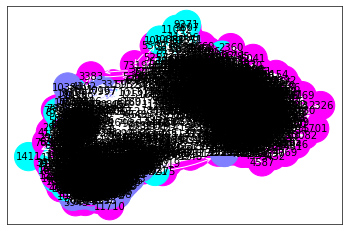

In [120]:
explainer = GNNExplainer(model, epochs=200, num_hops=None)
node_idx = idxoi[0]
node_feat_mask, edge_mask = explainer.explain_node(d, node_idx, d.x, d.edge_index)
# ax, G = explainer.visualize_subgraph(node_idx, d.edge_index, edge_mask, y=d.y, threshold=0., )


In [121]:
# save the output
imp = pd.DataFrame({'Gene':featnames, 'node_feat_mask':node_feat_mask})
imp.to_csv(os.path.join(pfp, 'node_feat_mask_Tcell_in_severe_cluster.csv'))
imp['rand_pos'] = np.random.uniform(size=(imp.shape[0],))
imp = imp.sort_values(by='node_feat_mask', ascending=False) # sort values
imp.index = list(range(imp.shape[0])) # reindex to be able to use .loc

500

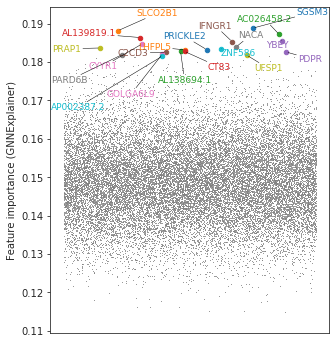

In [180]:
fig, ax = plt.subplots(1,1, figsize=(5,6))
sns.scatterplot(x='rand_pos',
                y='node_feat_mask',
               data=imp, color='gray',
               linewidth=0, s=3,
               rasterized=True,
               ax=ax)
sns.histplot(x='rand_pos', 
             y='node_feat_mask', 
             data=imp,
             bins=20, 
             pthresh=.1, 
             cmap="mako",
             alpha=0.4,
            ax=ax)
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('Feature importance (GNNExplainer)')
ax.set_title('')

ntop = 20
[ax.scatter(imp.loc[i, 'rand_pos'], imp.loc[i, 'node_feat_mask'], s=20, color=sns.color_palette()[(i-10) % 10]) for i in range(ntop)]
# texts = [ax.text(imp.loc[i, 'rand_pos'], imp.loc[i, 'node_feat_mask'], imp.loc[i, 'Gene'], fontsize=9, bbox=dict(facecolor='white',edgecolor='black')) for i in range(ntop)]
texts = [ax.text(imp.loc[i, 'rand_pos'], imp.loc[i, 'node_feat_mask'], imp.loc[i, 'Gene'], fontsize=9, color=sns.color_palette()[(i-10) % 10]) for i in range(ntop)]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=0.5), expand_text=(1.5,1.5))

if savefigs:
    fig.savefig(os.path.join(pfp, 'node_feat_mask_scatter_feat_imp_Tcells_severe_cluster.pdf'), bbox_inches='tight')

Explain node 2208: 100%|██████████| 100/100 [00:08<00:00, 12.07it/s]


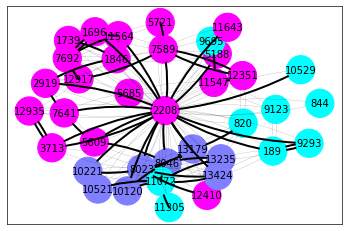

In [259]:
# # # get first order neighborhood graph
explainer = GNNExplainer(model, epochs=100, num_hops=1)
node_idx = idxoi[0]
node_feat_mask, edge_mask = explainer.explain_node(d, node_idx, d.x, d.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, d.edge_index, edge_mask, y=d.y, threshold=0.28)

# pos = nx.spring_layout(G, iterations=100)
# nx.draw(G, pos, node_color='k', node_size=800, cmap=plt.cm.Blues)
# plt.show()

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, d.edge_index, 100*edge_mask, y=d.y)

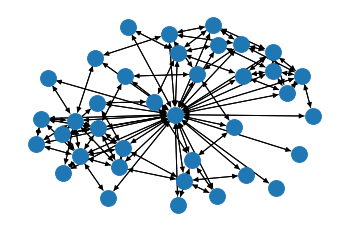

In [214]:
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=250)

# edges
nx.draw_networkx_edges(G, pos, arrows=False)
# nx.draw_networkx_edges(
#     G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
# )

# labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

plt.axis("off")
plt.show()

In [230]:
edge_index_sub[]

torch.Size([2, 37])

In [233]:
G.edges

EdgeView([(tensor(2208), tensor(189)), (tensor(2208), tensor(820)), (tensor(2208), tensor(844)), (tensor(2208), tensor(1696)), (tensor(2208), tensor(1739)), (tensor(2208), tensor(1846)), (tensor(2208), tensor(2208)), (tensor(2208), tensor(2919)), (tensor(2208), tensor(3713)), (tensor(2208), tensor(5188)), (tensor(2208), tensor(5609)), (tensor(2208), tensor(5685)), (tensor(2208), tensor(5721)), (tensor(2208), tensor(7589)), (tensor(2208), tensor(7641)), (tensor(2208), tensor(7692)), (tensor(2208), tensor(8023)), (tensor(2208), tensor(8046)), (tensor(2208), tensor(9123)), (tensor(2208), tensor(9293)), (tensor(2208), tensor(9695)), (tensor(2208), tensor(10120)), (tensor(2208), tensor(10221)), (tensor(2208), tensor(10521)), (tensor(2208), tensor(10529)), (tensor(2208), tensor(11072)), (tensor(2208), tensor(11305)), (tensor(2208), tensor(11547)), (tensor(2208), tensor(11564)), (tensor(2208), tensor(11643)), (tensor(2208), tensor(12351)), (tensor(2208), tensor(12410)), (tensor(2208), tensor(

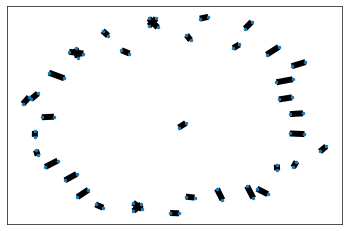

In [235]:

edge_mask_sub = edge_mask[d.edge_index[0,:]==node_idx].numpy()
edge_index_sub = d.edge_index[:,d.edge_index[0,:]==node_idx]

G = nx.Graph()
for i in range(edge_mask_sub.shape[0]):
    G.add_edge(edge_index_sub[0, i], edge_index_sub[1, i], weight=edge_mask_sub[i])


pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=6)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.0]

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)

In [225]:
edge_mask[d.edge_index[0,:]==node_idx].shape

torch.Size([37])

In [76]:
d.y[d.edge_index[1,d.edge_index[0,:]==node_idx]]

IndexError: too many indices for tensor of dimension 1

In [79]:
d.y[d.edge_index[1,d.edge_index[0,:]==node_idx]]

tensor([0, 0, 0, 1, 1, 1, 3, 3, 3, 5, 5, 5])

In [91]:
d.edge_index[:, edge_mask.nonzero()]

tensor([[[  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [  10],
         [1052],
         [1052],
         [1052],
         [1052],
         [1052],
         [1432],
         [1432],
         [1432],
         [1432],
         [3818],
         [3818],
         [4233],
         [4233],
         [5048],
         [5048],
         [5486],
         [5486],
         [5486],
         [5486],
         [6620],
         [6620],
         [6620],
         [6846],
         [6846],
         [6846],
         [6846],
         [6846],
         [7907],
         [7907],
         [7907],
         [8735],
         [8735],
         [8751],
         [8751]],

        [[  10],
         [1052],
         [1432],
         [3818],
         [4233],
         [5048],
         [5486],
         [6620],
         [6846],
         [7907],
         [8735],
         [8751],
         [  

In [96]:
edge_mask[edge_mask.nonzero()]

tensor([[0.0702],
        [0.0587],
        [0.0814],
        [0.0751],
        [0.0777],
        [0.9394],
        [0.0847],
        [0.0688],
        [0.0805],
        [0.9428],
        [0.0809],
        [0.0799],
        [0.0845],
        [0.0795],
        [0.9428],
        [0.0736],
        [0.0710],
        [0.0828],
        [0.0779],
        [0.9396],
        [0.0710],
        [0.0550],
        [0.9396],
        [0.9395],
        [0.0774],
        [0.9394],
        [0.0722],
        [0.0829],
        [0.0752],
        [0.0781],
        [0.0761],
        [0.0665],
        [0.0837],
        [0.0750],
        [0.0792],
        [0.0835],
        [0.0835],
        [0.0846],
        [0.0814],
        [0.0846],
        [0.9408],
        [0.0825],
        [0.0753],
        [0.0820],
        [0.0632],
        [0.0742]])